# Clasificación de sargazo

Notebook inicial para clasificar el nivel de sargazon en imágenes de la playa. El notebook incuye varias redes neuronales profundas que se pueden usar preentrenadas o sin entrenamiento previo. Tu puedes dividir el conjunto de datos entre entrenamiento y validación. 

Si encuentras util el ćodigo te recomiendo que revises nuestro arítuclo científico que describe el problema.

https://www.mdpi.com/2076-3417/12/19/10012


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
import os
import time
import copy

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms, utils
import torch.optim as optim
import sklearn
import sklearn.model_selection as skl
import seaborn as sn
%matplotlib inline
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
print("Torch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)
!python --version

cuda:0
Torch version:  2.6.0.dev20241220+cu126
Torchvision version:  0.22.0.dev20241220+cu126
Python 3.12.6


In [5]:
# Directorio de la carpeta donde esta el dataset
img_folder = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\\clasifica-el-sargazo-24-b\\images_public'
csv_file = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\\clasifica-el-sargazo-24-b\\train_data.csv'

# Hyper parameters
epochs = 20
current_epoch = 0
batch_size = 64
learning_rate = 0.001
run_training = True #Si deseamos que el notebook ejecute el entrenamiento
model_name = 'vgg' # Red a cargar
pretrained = True # True indica que la red se va a inicializar con los parámetros entrenados
feature_extract = False #True indica que no se actualizan los parámetros
save_weights = True

wts_str = 'w_' + model_name + '_pret_' + str(pretrained) + '_feat_' + str(feature_extract) + '_lr_'+ str(learning_rate) 
print(wts_str)

w_vgg_pret_True_feat_False_lr_0.001


## Objeto dataset

En PyTorch, un objeto Dataset se encarga de almacenar y manejar los datos que se usarán en modelos de aprendizaje automático. Es una clase abstracta de la cual se derivan clases específicas para manejar diferentes tipos de datos.  En este caso el objeto se implementa para leer de cada imagen su correspondiente etiqueta.

In [6]:
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        """
        Args:
            txt_frame_file (string): Path to the txt files with labels.
            images_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sargazo_frame = dataframe
        self.root_dir = images_path
        self.transform = transform
        self.class2id = {
            'nada': 0, 
            'bajo': 1, 
            'moderado': 2, 
            'abundante': 3, 
            'excesivo': 4
        }
        
        # Validate all labels in dataframe
        self._validate_labels()
    
    def _validate_labels(self):
        invalid_labels = self.sargazo_frame['Category'].apply(
            lambda x: x not in self.class2id
        )
        if invalid_labels.any():
            bad_labels = self.sargazo_frame.loc[invalid_labels, 'Category'].unique()
            raise ValueError(f"Invalid labels found: {bad_labels}")
    
    def pil_loader(self, path):
        try:
            with open(path, 'rb') as f:
                img = Image.open(f)
                return img.convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Failed to load image {path}: {str(e)}")

    def __len__(self):
        return len(self.sargazo_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        try:
            image_path = os.path.join(self.root_dir, self.sargazo_frame.iloc[idx, 0])
            image = self.pil_loader(image_path)
            label = self.sargazo_frame.iloc[idx]['Category']
            
            if self.transform:
                image = self.transform(image)
                
            return image, self.class2id[label]
            
        except Exception as e:
            raise RuntimeError(f"Error processing index {idx}: {str(e)}")

## Dividir conjunto de datos

In [7]:
class2id = test_count = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {0: 'nada', 1: 'bajo', 2: 'moderado', 3: 'abundante', 4: 'excesivo'}
num_classes = len(id2class)

full_dataset = pd.read_csv(csv_file) 
full_dataset.sample(5)

,Id,Category
1226,k0251.jpg,nada
1837,r339.jpg,bajo
1630,s0666.jpg,nada
377,k0319.jpg,nada
618,k0485.jpg,moderado


In [8]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

col_labels = 'Category'
random_state = 46
full_dataset[col_labels] = full_dataset[col_labels].str.strip()
train_df, valid_df = skl.train_test_split(
    full_dataset, 
    test_size=0.2, 
    stratify=full_dataset[col_labels], 
    random_state=random_state
)

training_dataset = SargazoDataset(train_df, img_folder, transform=transform)
test_dataset = SargazoDataset(valid_df, img_folder, transform=transform)

print(f"Training samples: {len(training_dataset)}")

def show_image(image, label):
    plt.imshow(image, cmap = 'gray')
    plt.pause(0.001) 



Training samples: 1956


## Mostrar unos ejemplos

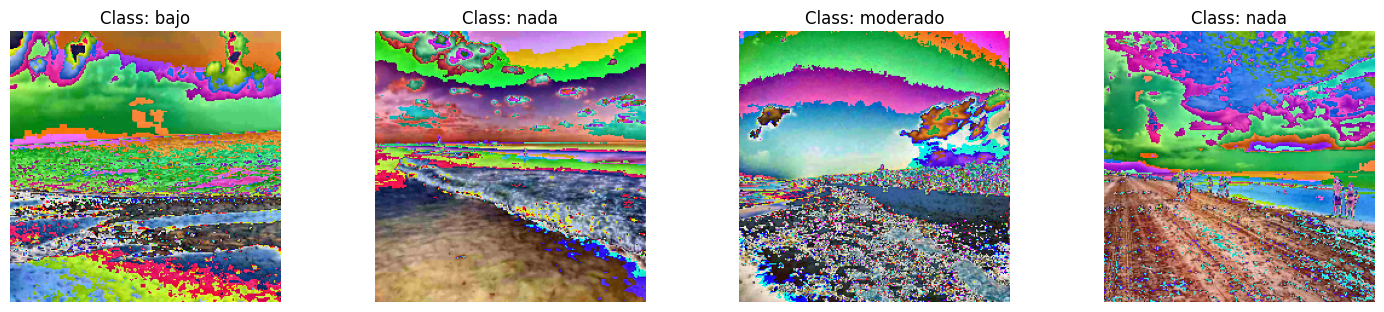

In [9]:
def show_samples(dataset, num_samples=4):
    fig = plt.figure(figsize=(15, 4))
    
    for i in range(num_samples):
        image, label = dataset[i]
        
        # Convert tensor to PIL image for display
        if torch.is_tensor(image):
            image = transforms.ToPILImage()(image)
        
        ax = plt.subplot(1, num_samples, i + 1)
        plt.tight_layout(pad=3.0)
        ax.set_title(f'Class: {id2class[label]}')
        ax.axis('off')
        plt.imshow(image)
    
    plt.show()

show_samples(training_dataset)

## Descenso por gradiente

Implementación del descenso por gradiente.

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs = 25, is_inception= False, save_after = 100):
    since = time.time()
    
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    #print(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        
        #Each epoch as a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in iter(dataloaders[phase]):
                #print(inputs)
                #print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero the parameter gradients
                optimizer.zero_grad()
                
                #forward
                # track history
                with torch.set_grad_enabled(phase == 'train'):
                    
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss /len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), wts_str + '_best.pt')
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            if phase == 'train' and epoch % save_after == 0 :
                torch.save(model.state_dict(), wts_str + '_epoch' + str(epoch) + '.pt')
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    #load the best model
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

In [11]:
# set model parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # Freeze parameters
            param.requires_grad = False

## Crear modelo de red neuronal

In [12]:
# Initialize and reshape the networks
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        #model_ft = models.vgg16(weights='IMAGENET1K_V1')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pretrained)

# Print the model we just instantiated
print(model_ft)

model_ft.to(device)

C:\Users\yleob\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yleob\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\yleob/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Entrenamiento

In [13]:
data_transforms = {
    'train': transforms.Compose([
        # Randomly resize and crop the image to 224x224
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),  # Flip images randomly
        transforms.ToTensor(),
        # Normalize with ImageNet mean and std values
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # Resize the image and crop the center to 224x224
        transforms.Resize(256),  # Resize to a size larger than 224x224
        transforms.CenterCrop(224),  # Crop to 224x224
        transforms.ToTensor(),
        # Normalize with ImageNet mean and std values
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [14]:
from torchvision import transforms
from PIL import Image
import torch

# 1. Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Custom collate function
def custom_collate(batch):
    images = []
    labels = []
    for img, label in batch:
        if isinstance(img, Image.Image):
            img = transform(img)
        images.append(img)
        labels.append(label)
    return torch.stack(images), torch.tensor(labels)

# 3. Update DataLoader configuration
dataloaders_dict = {
    'train': torch.utils.data.DataLoader(
        training_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        collate_fn=custom_collate
    ),
    'val': torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=custom_collate
    )
}

# 4. Setup training components
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training execution
try:
    if run_training:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            criterion = criterion.cuda()
            
        model_ft, hist, hist_t, loss_hist, loss_hist_t = train_model(
            model_ft, 
            dataloaders_dict, 
            criterion, 
            optimizer_ft, 
            num_epochs=epochs, 
            is_inception=(model_name=="inception")
        )
except Exception as e:
    print(f"Error occurred: {e}")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
finally:
    import gc
    gc.collect()

Epoch 0/19
train Loss: 1.8130 Acc: 0.3937
val Loss: 1.3861 Acc: 0.4765

Epoch 1/19
train Loss: 1.3157 Acc: 0.4591
val Loss: 1.2035 Acc: 0.4867

Epoch 2/19
train Loss: 1.2621 Acc: 0.4749
val Loss: 1.1781 Acc: 0.4908

Epoch 3/19
train Loss: 1.1996 Acc: 0.4831
val Loss: 1.1503 Acc: 0.4969

Epoch 4/19
train Loss: 1.2019 Acc: 0.4939
val Loss: 1.1501 Acc: 0.4969

Epoch 5/19
train Loss: 1.1579 Acc: 0.5020
val Loss: 1.1731 Acc: 0.4969

Epoch 6/19
train Loss: 1.1494 Acc: 0.5066
val Loss: 1.1543 Acc: 0.4826

Epoch 7/19
train Loss: 1.1032 Acc: 0.5312
val Loss: 1.1452 Acc: 0.5297

Epoch 8/19
train Loss: 1.0892 Acc: 0.5332
val Loss: 1.0756 Acc: 0.5317

Epoch 9/19
train Loss: 1.0550 Acc: 0.5695
val Loss: 1.0647 Acc: 0.5726

Epoch 10/19
train Loss: 1.0423 Acc: 0.5649
val Loss: 1.1536 Acc: 0.4867

Epoch 11/19
train Loss: 1.0099 Acc: 0.5726
val Loss: 1.2128 Acc: 0.5317

Epoch 12/19
train Loss: 0.9970 Acc: 0.5854
val Loss: 1.3480 Acc: 0.4417

Epoch 13/19
train Loss: 0.9851 Acc: 0.5915
val Loss: 1.0876 A

In [15]:
# create the optimizer
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
            
optimizer_ft = optim.SGD(params_to_update, lr=learning_rate,momentum=0.9)
criterion = nn.CrossEntropyLoss()

Params to learn
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [16]:
from datetime import datetime

if save_weights:
    save_path = f"{wts_str}_{model_name}_epoch{epochs}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
    torch.save(model_ft.state_dict(), save_path)
    print(f"Pesos del modelo guardados en: {save_path}")

## Graficar resultados

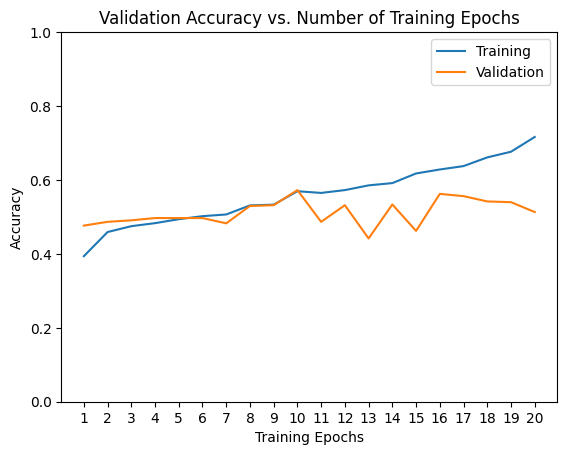

In [17]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
thist = []

vhist = [h.cpu().numpy() for h in hist]
thist = [h.cpu().numpy() for h in hist_t]
#shist = [h.cpu().numpy() for h in scratch_hist]

np.save('val_history', vhist)
np.save('train_history', vhist)

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,epochs+1),thist,label="Training")
plt.plot(range(1,epochs+1),vhist,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
file_name = wts_str + '_acc.png'
plt.savefig(file_name)
plt.show()

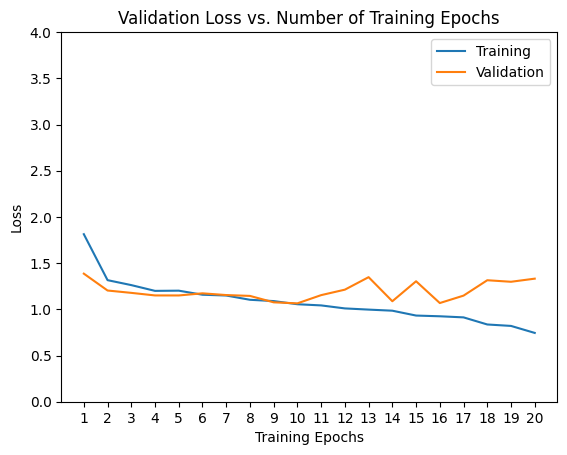

In [18]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist_loss = np.array(loss_hist)
thist_loss = np.array(loss_hist_t)

np.save('val_history', vhist_loss)
np.save('train_history', thist_loss)

plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1),thist_loss,label="Training")
plt.plot(range(1,epochs+1),vhist_loss,label="Validation")
plt.ylim((0,4.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
file_name = wts_str + '_loss.png'
plt.savefig(file_name)
plt.show()

In [19]:
def test_model(model, dataloaders):
    print("Evaluating model")
    print(time.time())
            
    # Iterate over data
    it = 0
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
                
        model.train(False)
        model.eval()
                    
        outputs = model(inputs)
                        
        _, preds = torch.max(outputs, 1)
        
        np_pred_labels = preds.cpu().numpy()
        np_real_labels = labels.cpu().numpy()
        if it == 0:
            pred_labels = np_pred_labels
            real_labels = np_real_labels
        else:
            pred_labels = np.concatenate((pred_labels,np_pred_labels))
            real_labels = np.concatenate((real_labels,np_real_labels))
        it= it+1
        
        del inputs
        del labels
        torch.cuda.empty_cache()
    
    print(time.time())
    return pred_labels,real_labels

In [20]:
predict_labels,actual_labels = test_model(model_ft, dataloaders_dict)

Evaluating model
1736373834.0100808
1736373884.3177834


In [21]:
from sklearn.metrics import classification_report
print(classification_report(actual_labels,predict_labels))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       233
           1       0.42      0.44      0.43       141
           2       0.00      0.00      0.00        45
           3       0.43      0.10      0.17        29
           4       0.57      0.63      0.60        41

    accuracy                           0.57       489
   macro avg       0.41      0.40      0.38       489
weighted avg       0.51      0.57      0.53       489



C:\Users\yleob\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yleob\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yleob\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [22]:
df_confusion = pd.crosstab(actual_labels, predict_labels,rownames=["True label"],colnames=["Predicted label"])
print(df_confusion)
df_confusion.rename(columns=id2class,index=id2class,inplace=True)
print(df_confusion)
df_confusion.to_csv('cm_exp5.csv')

Predicted label    0   1  3   4
True label                     
0                189  42  1   1
1                 69  62  1   9
2                 19  20  1   5
3                  5  16  3   5
4                  6   8  1  26
Predicted label  nada  bajo  abundante  excesivo
True label                                      
nada              189    42          1         1
bajo               69    62          1         9
moderado           19    20          1         5
abundante           5    16          3         5
excesivo            6     8          1        26


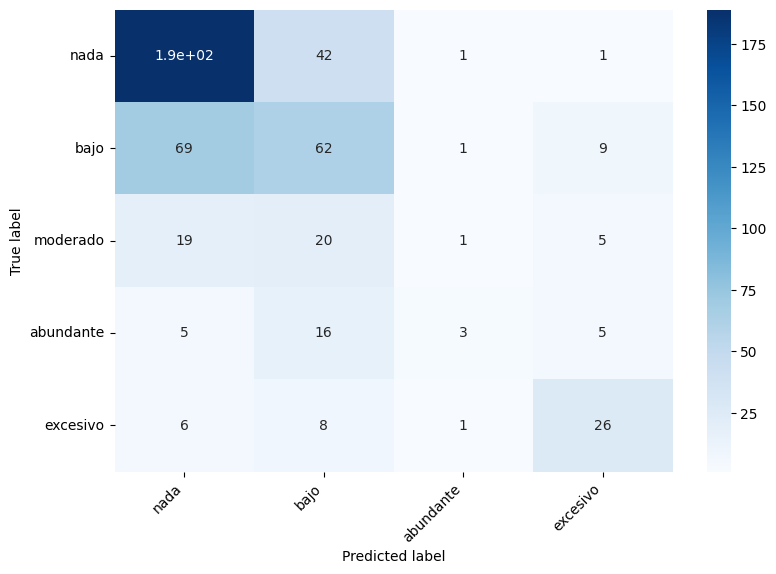

In [23]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_confusion, annot = True, cmap = 'Blues',ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5.eps",format = "eps",bbox_inches='tight')
plt.show()

In [24]:
df_norm_col= round(df_confusion.div(df_confusion.sum(axis=1),axis=0),2) 
print(df_norm_col)

Predicted label  nada  bajo  abundante  excesivo
True label                                      
nada             0.81  0.18       0.00      0.00
bajo             0.49  0.44       0.01      0.06
moderado         0.42  0.44       0.02      0.11
abundante        0.17  0.55       0.10      0.17
excesivo         0.15  0.20       0.02      0.63


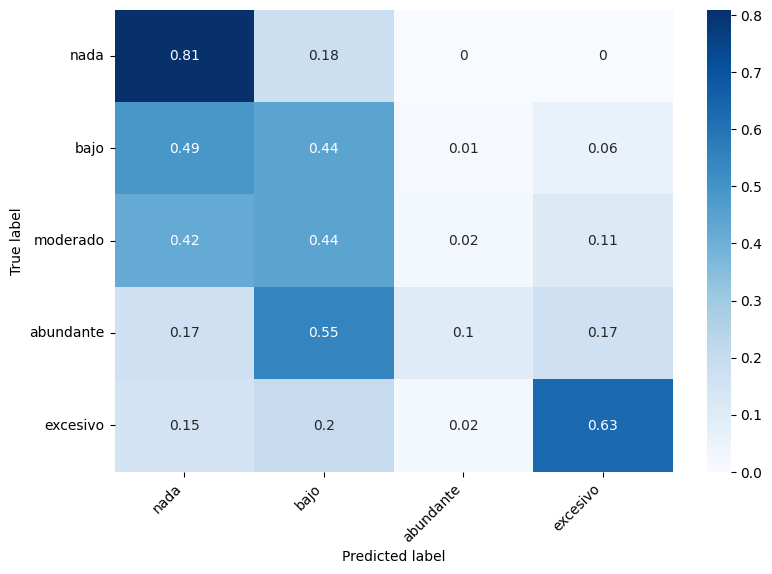

In [25]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_norm_col, annot = True, cmap = 'Blues')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5_norm.eps",format = "eps",bbox_inches='tight')
plt.show()

## Inferencia para el challenge

In [28]:
test_file = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\\clasifica-el-sargazo-24-b\\test_data.csv'

In [29]:
test_df = pd.read_csv(test_file) 
test_df.sample(5)


,Id
10,r058.jpg
149,j0251.jpg
263,s0731.jpg
134,k0801.jpg
265,s0217.jpg


In [34]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    
model_ft.eval()
test_predictions = []
for file in test_df['Id']:
    
    # cuidado si cambia la tabla se debe de cambiar esto
    image_path = os.path.join(img_folder, file)
    #print(image_path)
    
    image = pil_loader(image_path)
    img_transf = data_transforms['val'](image)
    img_transf = img_transf.unsqueeze(0)
    #print(img_transf.shape)
    
    #print(labels)
    img_transf = img_transf.to(device)
    
    outputs = model_ft(img_transf)
    #print(outputs)                    
    _, preds = torch.max(outputs, 1)
    test_predictions.append(id2class[preds.cpu().numpy()[0]])
    
#print(test_predictions)
# temp = {'Id': test_df['Id'], 'label': test_predictions}
# output_df = pd.DataFrame(data=temp)
# output_df.sample(10)

# Agregar columna de predicciones
test_df['Prediction'] = pd.Series(test_predictions)
test_df.to_csv('outputs.csv')